# Intro


#### This is a *work in progress*. Please <span style='color:#0a0'>upvote</span> the kernel to keep this going.

I have tried several public notebooks to find the best way for ensemble. Until now, this was the best outcome.

- The first notebook: https://www.kaggle.com/thebigd8ta/higher-lb-score-by-tuning-mloss-upgrade-1696e2
- The second notebook: https://www.kaggle.com/zhangxianjue/train-age?scriptVersionId=43259472

Note1: It is important to blend the best of each notebook. So I selected the best version of each notebook.

Note2: I will not be upgrading the code until the end of competition.


## Ensemble learning

Ensemble learning is the process by which multiple models, such as classifiers or experts, are strategically generated and combined to solve a particular computational intelligence problem. Ensemble learning is primarily used to improve the (classification, prediction, function approximation, etc.)

he motivation for using ensemble models is to reduce the generalization error of the prediction. As long as the base models are diverse and independent, the prediction error of the model decreases when the ensemble approach is used. The approach seeks the wisdom of crowds in making a prediction. Even though the ensemble model has multiple base models within the model, it acts and performs as a single model. Most of the practical data mining solutions utilize ensemble modeling techniques. 

![ens](https://cdn-images-1.medium.com/max/1000/0*sOtXk_8ZftGGU00_.png)

# Notebook 1

https://www.kaggle.com/thebigd8ta/higher-lb-score-by-tuning-mloss-upgrade-1696e2

Invalid requirement: '../input/kerasapplications/keras-team-keras-applications-3b180cb'
It looks like a path. File '../input/kerasapplications/keras-team-keras-applications-3b180cb' does not exist.
Invalid requirement: '../input/efficientnet/efficientnet-1.1.0/'
It looks like a path. File '../input/efficientnet/efficientnet-1.1.0/' does not exist.


In [1]:
import os
#import cv2
#import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
#from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
#from tensorflow_addons.optimizers import RectifiedAdam
#from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
##from tensorflow.keras.optimizers import Nadam
#import seaborn as sns
#import plotly.express as px
#import plotly.graph_objects as go
from PIL import Image
import keras

Using TensorFlow backend.


In [2]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [3]:
seed_everything(42)

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
#BATCH_SIZE = BATCH_SIZE*strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


## 2.1. Commit now <a class="anchor" id="2.1"></a>

[Back to Table of Contents](#0.1)

In [5]:
Dropout_model = 0.38559
FVC_weight = 0.2
Confidence_weight = 0.15

## 3. Download data, auxiliary functions and model tuning <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [6]:
#train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 

training = pd.read_csv("/media/jacoblamkey/Storage/training.csv")
testing = pd.read_csv("/media/jacoblamkey/Storage/testing.csv")

In [7]:
y = training['X.y.train.Yield.'].values  # train target
del training['X.y.train.Yield.']   # fetures (1535, 9)
#del vl_p['X.y.train.Yield.']   # fetures (1535, 9)

ze = testing.values  # fetures of submission (730, 9) e: estimate
z = training.values
print(ze.shape) 
nh = z.shape[1] 
print(nh)  # feature numbers (9,)

(10337, 3)
3


In [75]:

C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    
    
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.1, 0.50, 0.85]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss


def make_model(nh,D,ML):
    #ML=ML
    z = L.Input((nh,), name="Patient")
    x = L.Dense(D, activation="relu", name="d1")(z)
    #x = L.Dense(D, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    preds = L.Dense(3, activation="relu", name="p2")(x)
    #preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
    #                 name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(ML), optimizer="adam", 
                  metrics=tf.keras.metrics.RootMeanSquaredError(
    name="root_mean_squared_error", dtype=None))
    return model

my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=100,monitor="val_loss"),
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
     #                         patience=50, min_lr=0.001
#),
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


In [76]:
with strategy.scope():    
    net = make_model(nh,D=50,ML=.65)
    print(net.summary())
    print(net.count_params())
    NFOLD = 2 # originally 5
    kf = KFold(n_splits=NFOLD,shuffle=True)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Patient (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
d1 (Dense)                   (None, 50)                200       
_________________________________________________________________
p2 (Dense)                   (None, 3)                 153       
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
None
353


In [84]:
#del(pe)
#del(pred)
pe = np.zeros((ze.shape[0], 3))  #estimate of prediction
pred = np.zeros((z.shape[0], 3))  # prediction of truth ground
cnt = 0
EPOCHS = 100
D=128
ML=.2
BATCH_SIZE=512
y = y.astype(np.float32)
#for tr_idx, val_idx in kf.split(z):
#cnt += 1
#print(f"FOLD {cnt}")
net = make_model(nh,D,ML)
net.fit(z, y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2) #
print("train", net.evaluate(z, y, verbose=0, batch_size=BATCH_SIZE))
#print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
print("predict val...")
pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
print("predict test...")
pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD
    
valpred = pred[:, 0] - pred[:, 2]
np.corrcoef(y, valpred)



Epoch 1/100
182/182 - 1s - loss: 7.0109 - root_mean_squared_error: 44.3738
Epoch 2/100
182/182 - 1s - loss: 6.8639 - root_mean_squared_error: 40.1143
Epoch 3/100
182/182 - 1s - loss: 6.7939 - root_mean_squared_error: 39.1170
Epoch 4/100
182/182 - 1s - loss: 6.7600 - root_mean_squared_error: 38.7144
Epoch 5/100
182/182 - 1s - loss: 6.7460 - root_mean_squared_error: 38.5260
Epoch 6/100
182/182 - 1s - loss: 6.7338 - root_mean_squared_error: 38.2779
Epoch 7/100
182/182 - 1s - loss: 6.7247 - root_mean_squared_error: 38.0849
Epoch 8/100
182/182 - 1s - loss: 6.7124 - root_mean_squared_error: 37.8670
Epoch 9/100
182/182 - 1s - loss: 6.7028 - root_mean_squared_error: 37.7086
Epoch 10/100
182/182 - 1s - loss: 6.5564 - root_mean_squared_error: 36.7018
Epoch 11/100
182/182 - 1s - loss: 4.9146 - root_mean_squared_error: 24.0260
Epoch 12/100
182/182 - 1s - loss: 4.8566 - root_mean_squared_error: 23.3481
Epoch 13/100
182/182 - 1s - loss: 4.8229 - root_mean_squared_error: 22.9646
Epoch 14/100
182/182 

array([[ 1.        , -0.00344497],
       [-0.00344497,  1.        ]])

In [78]:
valpred = pred[:, 0] - pred[:, 2]
np.corrcoef(y, valpred)

array([[ 1.        , -0.05073107],
       [-0.05073107,  1.        ]])

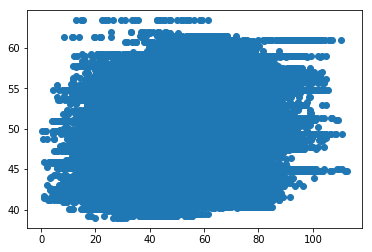

In [79]:
import matplotlib.pyplot as plt


plt.plot(y, pred[:, 1],"o")
plt.show()

12.381881337397425 35.83325062598941


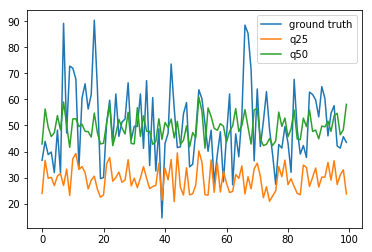

22.861408233642578 35.83325062598941 52.05254364013672 1.0


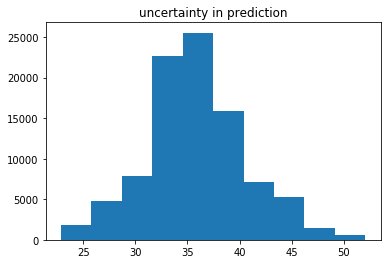

In [80]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
#plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [52]:
pe.shape

(10337, 3)

In [53]:
#sub['moistureOffPercent1'] = 1.*pe[:, 1]
predictions = pe[:, 2] - pe[:, 0] 


In [55]:
np.save('/media/jacoblamkey/Storage/submission', predictions)
